# Torch Batteries Example: Function Fitting with MLP

This notebook demonstrates how to use the `torch-batteries` library to train a Multi-Layer Perceptron (MLP) for function fitting. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps.

## Overview

We'll be fitting a polynomial function: `y = (x-1)(x-6)(x-7)` using a neural network with the Battery trainer class.

## 1. Setup and Dependencies

First, let's import the required libraries and check the versions of torch-batteries and PyTorch.

In [1]:
# Import torch-batteries and other dependencies
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.2.0
PyTorch version: 2.9.1


## 2. Data Preparation

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and split it into training, validation, and test sets.

In [2]:
# Prepare data loaders
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x = np.linspace(0, 10, 300).reshape(-1, 1).astype(np.float32)
y = ((x - 1)*(x - 6)*(x - 7)).astype(np.float32)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

BATCH_SIZE = 16

pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 210
Validation samples: 45
Test samples: 45
Batch size: 16
Training batches: 14
Validation batches: 3
Test batches: 3


## 3. Model Definition and Training

Now we'll define our MLP model using the `@charge` decorator to specify what happens during training, validation, testing, and prediction steps. This event-driven approach makes the code more organized and follows a clear pattern.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

In [3]:
# Import torch-batteries components
import torch.nn as nn
from torch.nn import functional as F
from torch_batteries import Battery, Event, charge

# Define MLP model with charge decorators
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
    @charge(Event.TRAIN_STEP)
    def training_step(self, batch):
        """Define what happens in each training step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        return loss
    
    @charge(Event.VALIDATION_STEP)
    def validation_step(self, batch):
        """Define what happens in each validation step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss
    
    @charge(Event.TEST_STEP)
    def test_step(self, batch):
        """Define what happens in each test step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, batch):
        """Define what happens during prediction."""
        x = batch[0]
        pred = self(x)
        return pred

model = MLPModel(input_dim=1, hidden_dim=64, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(model, optimizer=optimizer)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=100
)

print("Training completed!")
print(f"Final Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {train_results['val_loss'][-1]:.6f}")

Starting training...


Epoch 100/100 [Validation]: 100%|██████████| 3/3 [00:00<00:00, 965.24it/s, Loss=2.2138]

Training completed!
Final Training Loss: 3.917005
Final Validation Loss: 2.213766


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [6]:
test_results = battery.test(test_loader)
print(f"Final Test Loss: {test_results['test_loss']:.6f}")

Epoch 1/1 [Test]: 100%|██████████| 3/3 [00:00<00:00, 325.84it/s, Loss=1.7617]

Final Test Loss: 1.761709


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to approximate the target function.

Epoch 1/1 [Predict]: 100%|██████████| 19/19 [00:00<00:00, 937.86it/s]


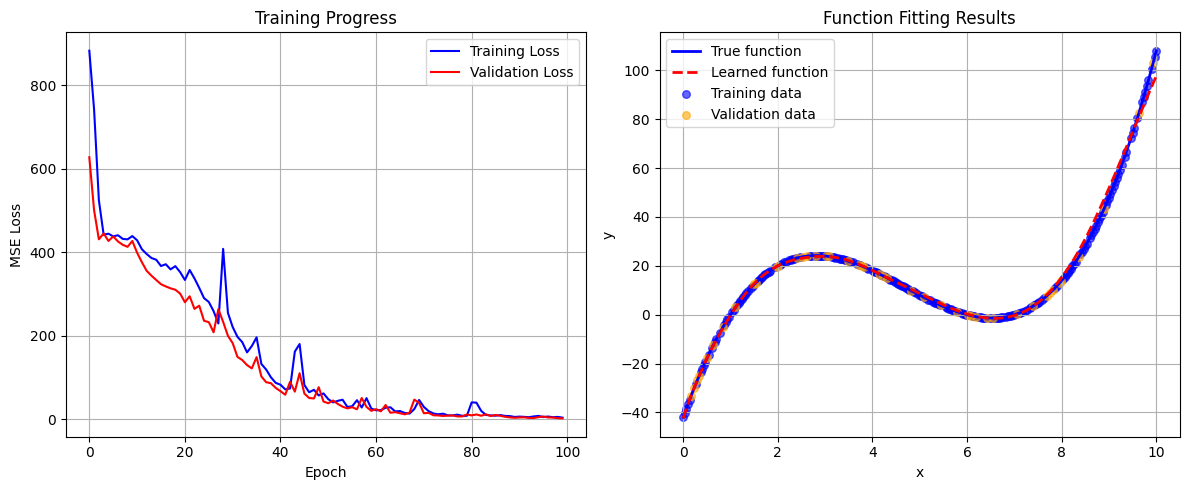

In [5]:
import matplotlib.pyplot as plt

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results['train_loss'], 'b-', label='Training Loss')
plt.plot(train_results['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

predictions = battery.predict(pred_full_loader)['predictions']

# Concatenate predictions
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

# Plot actual vs predicted function
plt.subplot(1, 2, 2)
plt.plot(x_np, y, 'b-', label='True function', linewidth=2)
plt.plot(x_np, y_pred, 'r--', label='Learned function', linewidth=2)
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, c='blue', label='Training data')
plt.scatter(x_val.numpy(), y_val.numpy(), alpha=0.6, s=30, c='orange', label='Validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Fitting Results')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()